In [36]:
#import cv2
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import pylab as pl
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, classification_report
from sklearn.cluster import MiniBatchKMeans
from preprocess import *
from classifiers_manager import *
import joblib
from collections import Counter
import cv2
%load_ext autoreload
%autoreload 2
from sklearnex import patch_sklearn
patch_sklearn()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Preprocessing &  Sift Features

In [41]:
A = load_Dataset("../../fonts-dataset/Scheherazade New/*.jpeg")
B= load_Dataset("../../fonts-dataset/Lemonada/*.jpeg")
C= load_Dataset("../../fonts-dataset/Marhey/*.jpeg")
D= load_Dataset("../../fonts-dataset/IBM Plex Sans Arabic/*.jpeg")

1000
1000
1000
1000


## Train Test Split

In [40]:
A, A_TEST = train_test_split(A, test_size=0)
B, B_TEST = train_test_split(B, test_size=0)
C, C_TEST = train_test_split(C, test_size=0.2)
D, D_TEST = train_test_split(D, test_size=0.2)

## Preprocessing

In [42]:
A_PROCESSED = []
for img in A:
    img=denoise(img)
    A_PROCESSED.append(img)
print("A: ", len(A_PROCESSED))
B_PROCESSED = []
for img in B:
    img=denoise(img)
    B_PROCESSED.append(img)
print("B: ", len(B_PROCESSED))
C_PROCESSED = []
for img in C:
    img=denoise(img)
    C_PROCESSED.append(img)
print("C: ", len(C_PROCESSED))
D_PROCESSED = []
for img in D:
    img=denoise(img)
    D_PROCESSED.append(img)
print("D: ", len(D_PROCESSED))

A:  1000
B:  1000
C:  1000
D:  1000


## SIFT Features

In [43]:
def extract_sift_features(image):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return descriptors

In [44]:
def prepare_data(images):
    # Extract SIFT features for each image
    features = [extract_sift_features(image) for image in images]
    
    # Filter out None values
    features = [desc for desc in features if desc is not None]
    
    # Convert the list of arrays into a single numpy array
    if features:
        features = np.vstack(features)
    else:
        features = np.array([])  # Return an empty array if no descriptors found
    return features

In [45]:
def create_codebook(features, num_clusters, batch_size):
    # Create a MiniBatchKMeans clustering object
    kmeans = MiniBatchKMeans(n_clusters=num_clusters, batch_size=batch_size, random_state=0)

    # Fit the clustering model to the SIFT features
    kmeans.fit(features)

    return kmeans

In [46]:
def compute_bovw_representation(features, codebook):
    num_clusters = codebook.n_clusters
    bovw_representation = []

    for image_features in features:
        if len(image_features) > 0:
            # Assign each feature to a cluster
            image_features=image_features.reshape(-1,128)
            cluster_assignments = codebook.predict(image_features)

            # Create a histogram of cluster frequencies
            histogram = np.bincount(cluster_assignments, minlength=num_clusters)

            # Normalize the histogram
            histogram = histogram / np.sum(histogram)

            bovw_representation.append(histogram)
        else:
            # Handle cases where no features were detected
            bovw_representation.append(np.zeros(num_clusters))

    return bovw_representation

## Extracting SIFT Features

In [47]:
A_PROCESSED= prepare_data(A_PROCESSED)
B_PROCESSED= prepare_data(B_PROCESSED)
C_PROCESSED= prepare_data(C_PROCESSED)
D_PROCESSED= prepare_data(D_PROCESSED)

In [48]:
train_labels= np.array([0]*len(A_PROCESSED) + [1]*len(B_PROCESSED) + [2]*len(C_PROCESSED) + [3]*len(D_PROCESSED))

In [49]:
print("A: ", A_PROCESSED[0].shape)
print("B: ", B_PROCESSED[0].shape)
print("C: ", C_PROCESSED[0].shape)
print("D: ", D_PROCESSED[0].shape)

A:  (1171, 128)
B:  (1541, 128)
C:  (444, 128)
D:  (658, 128)


In [50]:
A.clear()
B.clear()
C.clear()
D.clear()

In [51]:
combined_list = A_PROCESSED + B_PROCESSED + C_PROCESSED + D_PROCESSED
concatenated_train_sift_features = np.vstack(combined_list)
print(concatenated_train_sift_features.shape)

(10717340, 128)


In [52]:
print(len(combined_list))
print(len(train_labels))

3997
3997


In [53]:
A_PROCESSED.clear()
B_PROCESSED.clear()
C_PROCESSED.clear()
D_PROCESSED.clear()

## Kmeans Clustering for bag of words creation

In [54]:
num_clusters=100
batch_size=1000
codebook = create_codebook(concatenated_train_sift_features, 100, 1000)
print(codebook)

c:\Users\omara\.conda\envs\idp\lib\site-packages\sklearn\cluster\_kmeans.py:1972: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


MiniBatchKMeans(batch_size=1000, n_clusters=100, random_state=0)


In [55]:
joblib.dump(codebook, 'codebook.pkl')

['codebook.pkl']

In [56]:
train_bovw_features = compute_bovw_representation(combined_list, codebook)
train_bovw_features = np.array(train_bovw_features)
print(train_bovw_features.shape)
train_labels = np.array(train_labels)
print(train_labels.shape)

(3997, 100)
(3997,)


## Test Data Preprocessing

In [ ]:
A_TPROCESSED = []
for img in A_TEST:
    img=denoise(img)
    A_TPROCESSED.append(img)
print("A: ", len(A_TPROCESSED))
B_TPROCESSED = []
for img in B_TEST:
    img=denoise(img)
    B_TPROCESSED.append(img)
print("B: ", len(B_TPROCESSED))
C_TPROCESSED = []
for img in C_TEST:
    img=denoise(img)
    C_TPROCESSED.append(img)
print("C: ", len(C_TPROCESSED))
D_TPROCESSED = []
for img in D_TEST:
    img=denoise(img)
    D_TPROCESSED.append(img)
print("D: ", len(D_TPROCESSED))
 

A:  200
B:  200
C:  200
D:  200


In [ ]:
A_TEST.clear()
B_TEST.clear()
C_TEST.clear()
D_TEST.clear()

In [ ]:
A_TPROCESSED= prepare_data(A_TPROCESSED)
B_TPROCESSED= prepare_data(B_TPROCESSED)
C_TPROCESSED= prepare_data(C_TPROCESSED)
D_TPROCESSED= prepare_data(D_TPROCESSED)

In [ ]:
combined_test=A_TPROCESSED+B_TPROCESSED+C_TPROCESSED+D_TPROCESSED
print(len(combined_test))
test_bovw_features=compute_bovw_representation(combined_test,codebook)

800


In [ ]:
test_labels= np.array([0]*len(A_TPROCESSED) + [1]*len(B_TPROCESSED) + [2]*len(C_TPROCESSED) + [3]*len(D_TPROCESSED))

In [ ]:
A_TPROCESSED.clear()
B_TPROCESSED.clear()
C_TPROCESSED.clear()
D_TPROCESSED.clear()

## Grid Searching for the best models features

In [57]:
classifiers_manager = ClassifiersManager()
classifiers_manager.train_all_classifiers(train_bovw_features,train_labels)

c:\Users\omara\.conda\envs\idp\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


# Model Accuracy Metrics

In [26]:
classes = ['Scheherazade New', 'Lemonada', 'Marhey','IBM Plex Sans Arabic' ]

SVM
                      precision    recall  f1-score   support

    Scheherazade New       0.98      0.99      0.98       200
            Lemonada       1.00      0.99      1.00       200
              Marhey       0.99      0.97      0.98       200
IBM Plex Sans Arabic       0.99      1.00      1.00       200

            accuracy                           0.99       800
           macro avg       0.99      0.99      0.99       800
        weighted avg       0.99      0.99      0.99       800



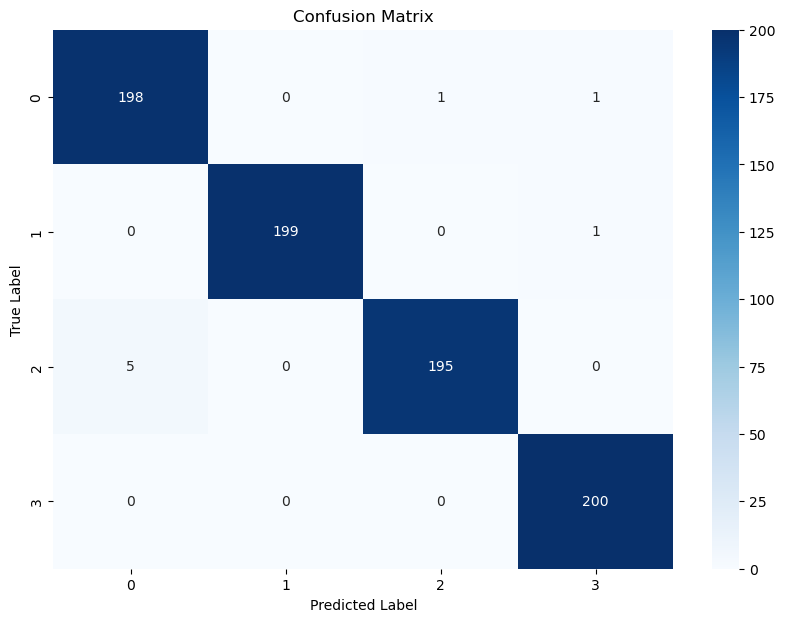

KNN
                      precision    recall  f1-score   support

    Scheherazade New       0.99      0.96      0.97       200
            Lemonada       1.00      0.99      0.99       200
              Marhey       0.96      0.99      0.97       200
IBM Plex Sans Arabic       0.99      0.99      0.99       200

            accuracy                           0.98       800
           macro avg       0.98      0.98      0.98       800
        weighted avg       0.98      0.98      0.98       800



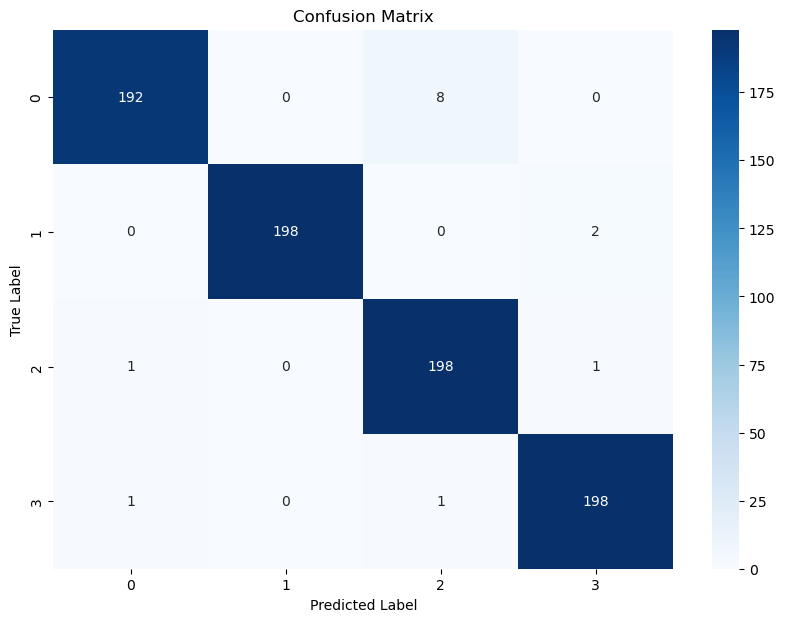

Random_Forest
                      precision    recall  f1-score   support

    Scheherazade New       0.97      0.99      0.98       200
            Lemonada       1.00      0.99      0.99       200
              Marhey       0.99      0.97      0.98       200
IBM Plex Sans Arabic       0.99      0.99      0.99       200

            accuracy                           0.98       800
           macro avg       0.99      0.99      0.99       800
        weighted avg       0.99      0.98      0.99       800



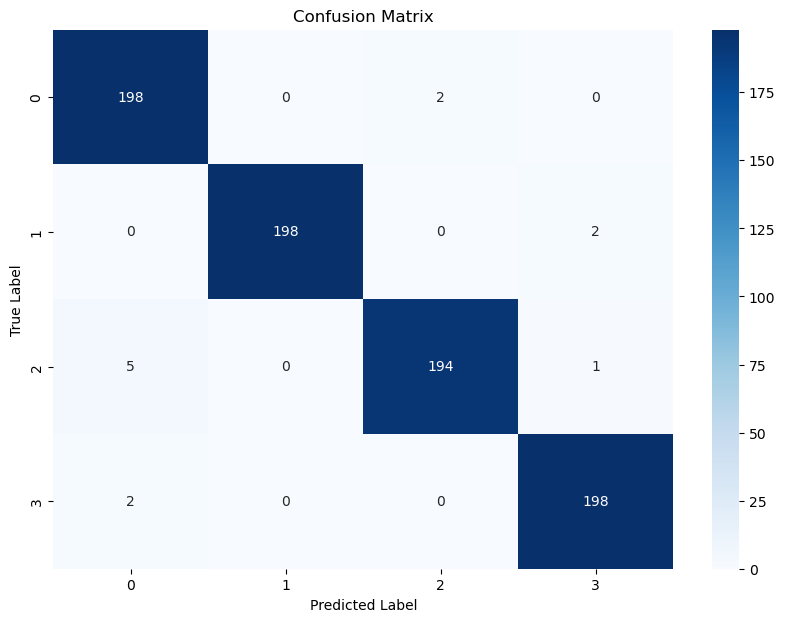

Decision_Tree
                      precision    recall  f1-score   support

    Scheherazade New       0.91      0.90      0.90       200
            Lemonada       0.98      0.96      0.97       200
              Marhey       0.90      0.92      0.91       200
IBM Plex Sans Arabic       0.93      0.94      0.93       200

            accuracy                           0.93       800
           macro avg       0.93      0.93      0.93       800
        weighted avg       0.93      0.93      0.93       800



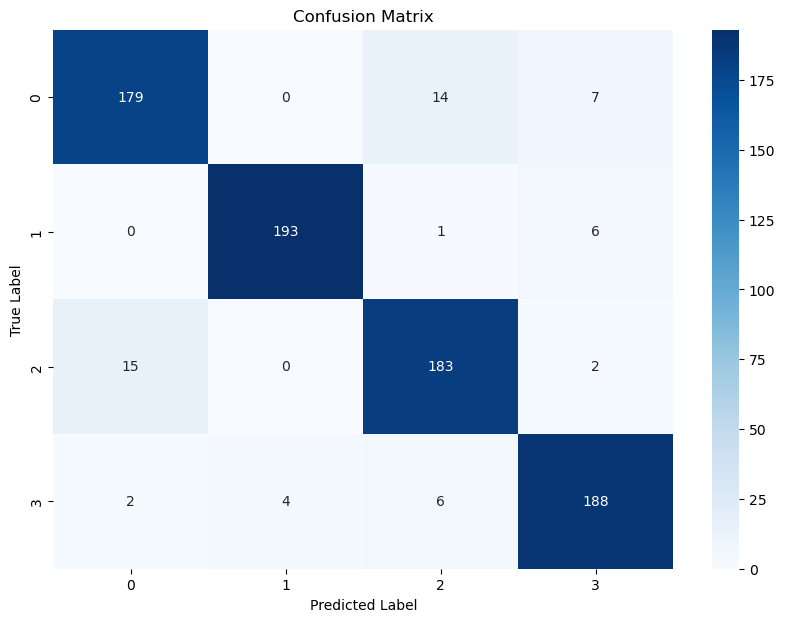

Adaboost
                      precision    recall  f1-score   support

    Scheherazade New       0.74      0.93      0.82       200
            Lemonada       0.81      0.96      0.88       200
              Marhey       0.90      0.67      0.76       200
IBM Plex Sans Arabic       0.92      0.74      0.82       200

            accuracy                           0.83       800
           macro avg       0.84      0.83      0.82       800
        weighted avg       0.84      0.83      0.82       800



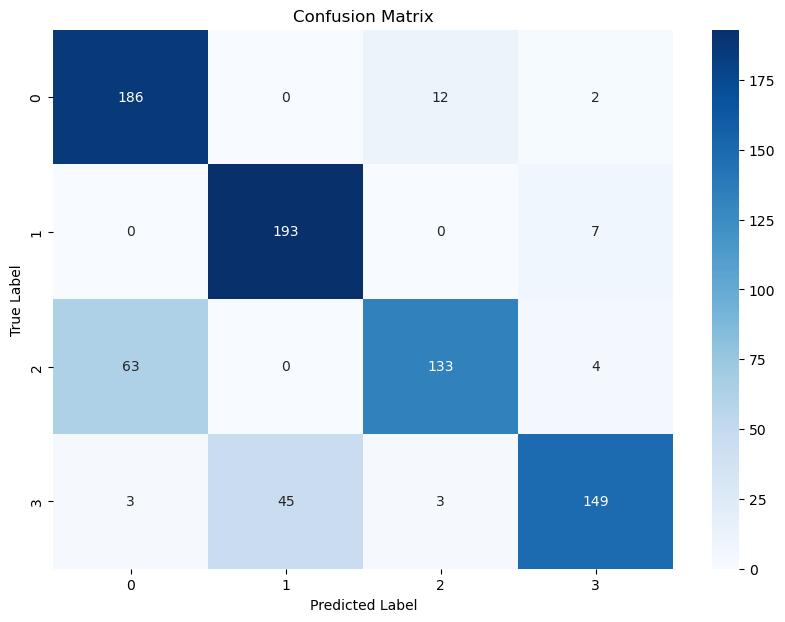

In [35]:
classifiers_manager.load_all_classifiers()
classifiers_manager.test_all_classifiers(test_bovw_features,test_labels,classes)
classifiers_manager.print_metrics()